In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
ERROR: Operation cancelled by user
     |████████████████████████████████| 3.5 MB 5.1 MB/s 


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np

import dgl
import dgl.function as fn
from dgl.data import GINDataset
from dgl.nn import GNNExplainer
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling, GNNExplainer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Explainability_name = 'GNNExplainer'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
#dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset = GINDataset('MUTAG', self_loop=False)

In [ ]:
print(len(dataset))

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0)

188


In [ ]:
print(len(train_dataset))
print(len(test_dataset))


131
57


# **Batching Data by DataLoader**

In [ ]:
torch.manual_seed(123456)
train_dataloader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = GraphDataLoader(test_dataset, batch_size=64, shuffle=False)

# **Model Designing**

In [ ]:
class Graph_Model(nn.Module):
  def __init__(self, in_feats, out_feats):
    super(Graph_Model, self).__init__()
    self.linear = nn.Linear(in_feats, out_feats)
    self.linear2 = nn.Linear(out_feats, out_feats)
    self.pool = AvgPooling()

  def forward(self, graph, feat, eweight=None):
    with graph.local_scope():
        feat = self.linear(feat)
        feat = self.linear2(feat)
        graph.ndata['h'] = feat
        if eweight is None:
            graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
        else:
            graph.edata['w'] = eweight
            graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
        return self.pool(graph, graph.ndata['h'])
             

In [ ]:
feat_size = train_dataset[0][0].ndata['attr'].shape[1]
GNN_Model = Graph_Model(feat_size, dataset.gclasses)

In [ ]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=1e-2)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  GNN_Model = Graph_Model(feat_size, dataset.gclasses)
  GNN_Model_Optimizer = torch.optim.Adam(params = GNN_Model.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GNN_Model.load_state_dict(checkpoint['model_state_dict'])
  GNN_Model_Optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GNN_Model, GNN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(GNN_Model_losses, epoch_history):
  GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(str(Explainability_name) + " Loss in Epoch: " + str(epoch_history))

  ax.plot(GNN_Model_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [ ]:
def train_step():
  GNN_Model_loss_batch = []

  GNN_Model.train()
  GNN_Model.zero_grad()
  for bg, labels in train_dataloader:
    logits = GNN_Model(bg, bg.ndata['attr'])

    batch_loss = loss_calculations(logits, labels)
    GNN_Model_loss_batch.append(batch_loss)

    batch_loss.backward()
    GNN_Model_Optimizer.step()
  
  return torch.mean(torch.tensor(GNN_Model_loss_batch))


In [ ]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
def train(EPOCHS, load_index):
  GNN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GNN_Model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GNN_Model_training_loss:.4f}')

    GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 001, GNNExplainer Model Loss: 0.8758
Epoch: 002, GNNExplainer Model Loss: 0.8163
Epoch: 003, GNNExplainer Model Loss: 0.7224
Epoch: 004, GNNExplainer Model Loss: 0.6927
Epoch: 005, GNNExplainer Model Loss: 0.6397
Epoch: 006, GNNExplainer Model Loss: 0.5589
Epoch: 007, GNNExplainer Model Loss: 0.7102
Epoch: 008, GNNExplainer Model Loss: 0.6246
Epoch: 009, GNNExplainer Model Loss: 0.7326
Epoch: 010, GNNExplainer Model Loss: 0.6194
Epoch: 011, GNNExplainer Model Loss: 0.6234
Epoch: 012, GNNExplainer Model Loss: 0.7169
Epoch: 013, GNNExplainer Model Loss: 0.7112
Epoch: 014, GNNExplainer Model Loss: 0.6945
Epoch: 015, GNNExplainer Model Loss: 0.5643
Epoch: 016, GNNExplainer Model Loss: 0.7559
Epoch: 017, GNNExplainer Model Loss: 0.6203
Epoch: 018, GNNExplainer Model Loss: 0.6144
Epoch: 019, GNNExplainer Model Loss: 0.6214
Epoch: 020, GNNExplainer Model Loss: 0.6139
Epoch: 021, GNNExplainer Model Loss: 0.7544
Epoch: 022, GNNExplainer Model Loss: 0.6839
Epoch: 023, GNNExplainer Model L

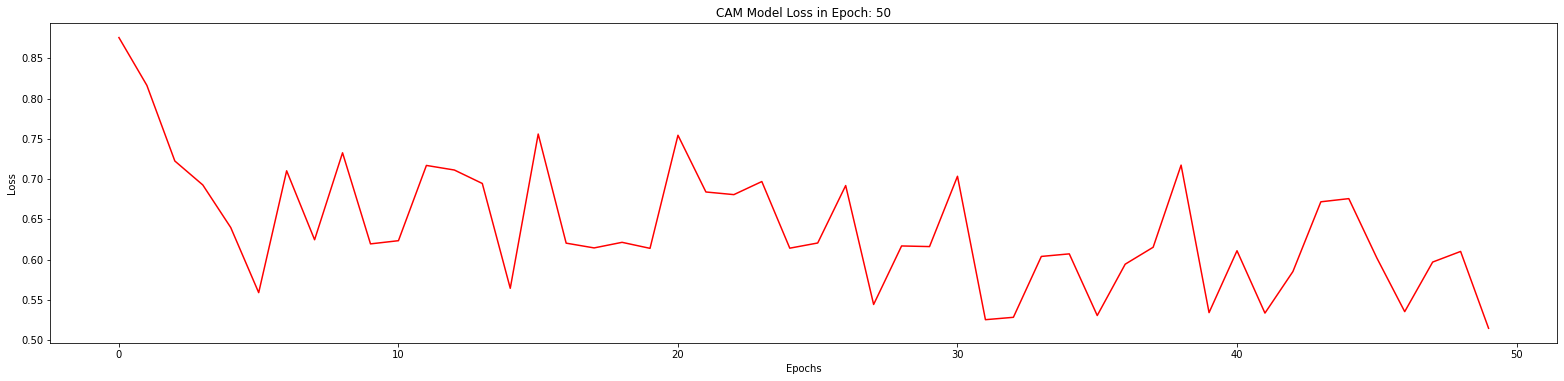

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 051, GNNExplainer Model Loss: 0.5806
Epoch: 052, GNNExplainer Model Loss: 0.5364
Epoch: 053, GNNExplainer Model Loss: 0.5249
Epoch: 054, GNNExplainer Model Loss: 0.6909
Epoch: 055, GNNExplainer Model Loss: 0.5782
Epoch: 056, GNNExplainer Model Loss: 0.5110
Epoch: 057, GNNExplainer Model Loss: 0.5300
Epoch: 058, GNNExplainer Model Loss: 0.5216
Epoch: 059, GNNExplainer Model Loss: 0.5592
Epoch: 060, GNNExplainer Model Loss: 0.4813
Epoch: 061, GNNExplainer Model Loss: 0.5706
Epoch: 062, GNNExplainer Model Loss: 0.5295
Epoch: 063, GNNExplainer Model Loss: 0.5474
Epoch: 064, GNNExplainer Model Loss: 0.4971
Epoch: 065, GNNExplainer Model Loss: 0.5685
Epoch: 066, GNNExplainer Model Loss: 0.4684
Epoch: 067, GNNExplainer Model Loss: 0.5220
Epoch: 068, GNNExplainer Model Loss: 0.5583
Epoch: 069, GNNExplainer Model Loss: 0.5729
Epoch: 070, GNNExplainer Model Loss: 0.5264
Epoch: 071, GNNExplainer Model Loss: 0.6590
Epoch: 072, GNNExplainer Model Loss: 0.5969
Epoch: 073, GNNExplainer Model L

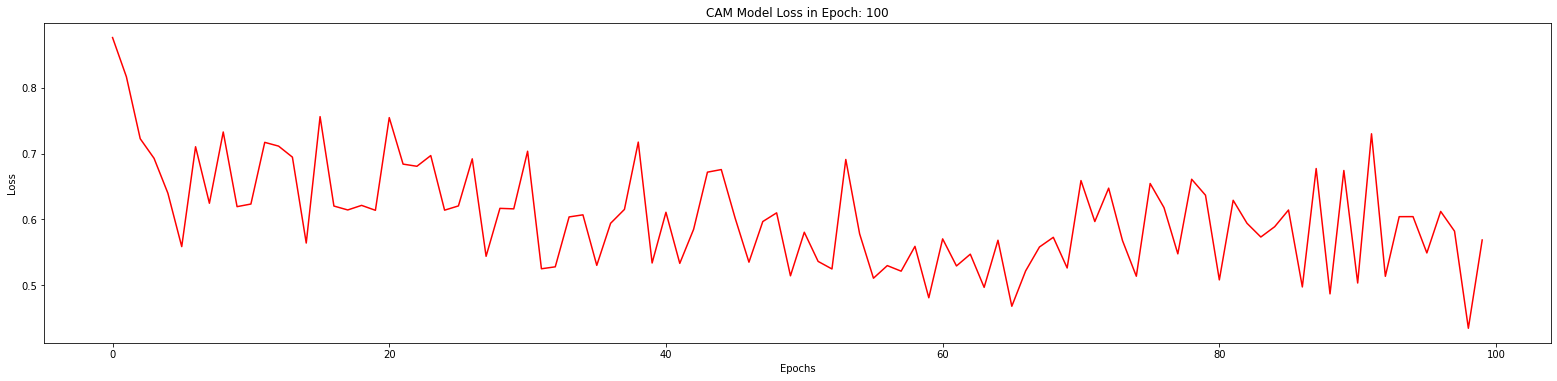

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 101, GNNExplainer Model Loss: 0.4590
Epoch: 102, GNNExplainer Model Loss: 0.5433
Epoch: 103, GNNExplainer Model Loss: 0.5940
Epoch: 104, GNNExplainer Model Loss: 0.5466
Epoch: 105, GNNExplainer Model Loss: 0.6112
Epoch: 106, GNNExplainer Model Loss: 0.6126
Epoch: 107, GNNExplainer Model Loss: 0.5522
Epoch: 108, GNNExplainer Model Loss: 0.6036
Epoch: 109, GNNExplainer Model Loss: 0.6115
Epoch: 110, GNNExplainer Model Loss: 0.6518
Epoch: 111, GNNExplainer Model Loss: 0.6056
Epoch: 112, GNNExplainer Model Loss: 0.6017
Epoch: 113, GNNExplainer Model Loss: 0.5455
Epoch: 114, GNNExplainer Model Loss: 0.5470
Epoch: 115, GNNExplainer Model Loss: 0.5678
Epoch: 116, GNNExplainer Model Loss: 0.4942
Epoch: 117, GNNExplainer Model Loss: 0.6872
Epoch: 118, GNNExplainer Model Loss: 0.6285
Epoch: 119, GNNExplainer Model Loss: 0.5828
Epoch: 120, GNNExplainer Model Loss: 0.5285
Epoch: 121, GNNExplainer Model Loss: 0.6020
Epoch: 122, GNNExplainer Model Loss: 0.5412
Epoch: 123, GNNExplainer Model L

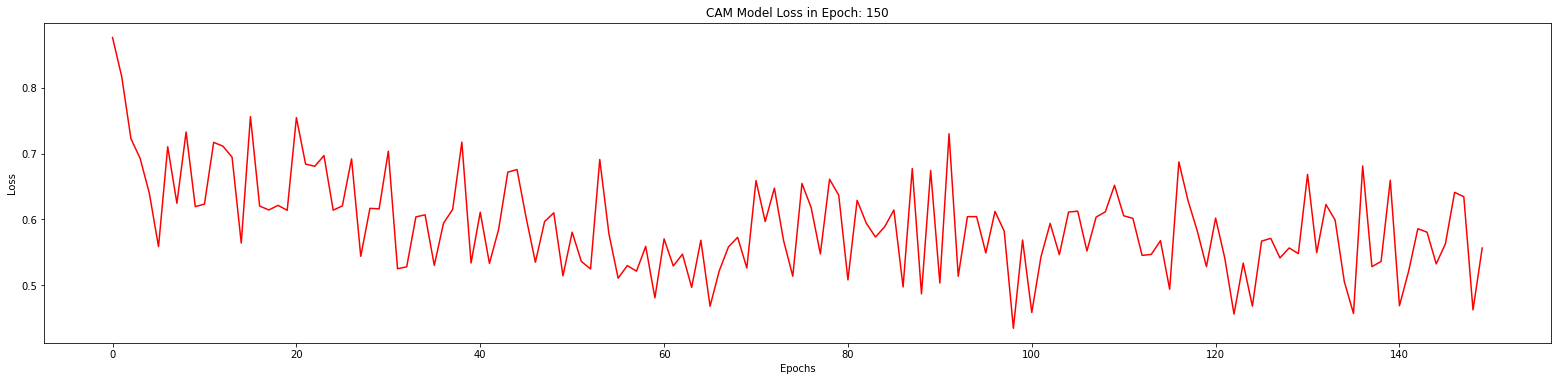

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 151, GNNExplainer Model Loss: 0.5808
Epoch: 152, GNNExplainer Model Loss: 0.5411
Epoch: 153, GNNExplainer Model Loss: 0.5756
Epoch: 154, GNNExplainer Model Loss: 0.5748
Epoch: 155, GNNExplainer Model Loss: 0.6227
Epoch: 156, GNNExplainer Model Loss: 0.5047
Epoch: 157, GNNExplainer Model Loss: 0.5466
Epoch: 158, GNNExplainer Model Loss: 0.4577
Epoch: 159, GNNExplainer Model Loss: 0.6374
Epoch: 160, GNNExplainer Model Loss: 0.6523
Epoch: 161, GNNExplainer Model Loss: 0.5557
Epoch: 162, GNNExplainer Model Loss: 0.6142
Epoch: 163, GNNExplainer Model Loss: 0.6634
Epoch: 164, GNNExplainer Model Loss: 0.6433
Epoch: 165, GNNExplainer Model Loss: 0.6604
Epoch: 166, GNNExplainer Model Loss: 0.6266
Epoch: 167, GNNExplainer Model Loss: 0.4679
Epoch: 168, GNNExplainer Model Loss: 0.5815
Epoch: 169, GNNExplainer Model Loss: 0.5558
Epoch: 170, GNNExplainer Model Loss: 0.5369
Epoch: 171, GNNExplainer Model Loss: 0.4744
Epoch: 172, GNNExplainer Model Loss: 0.4302
Epoch: 173, GNNExplainer Model L

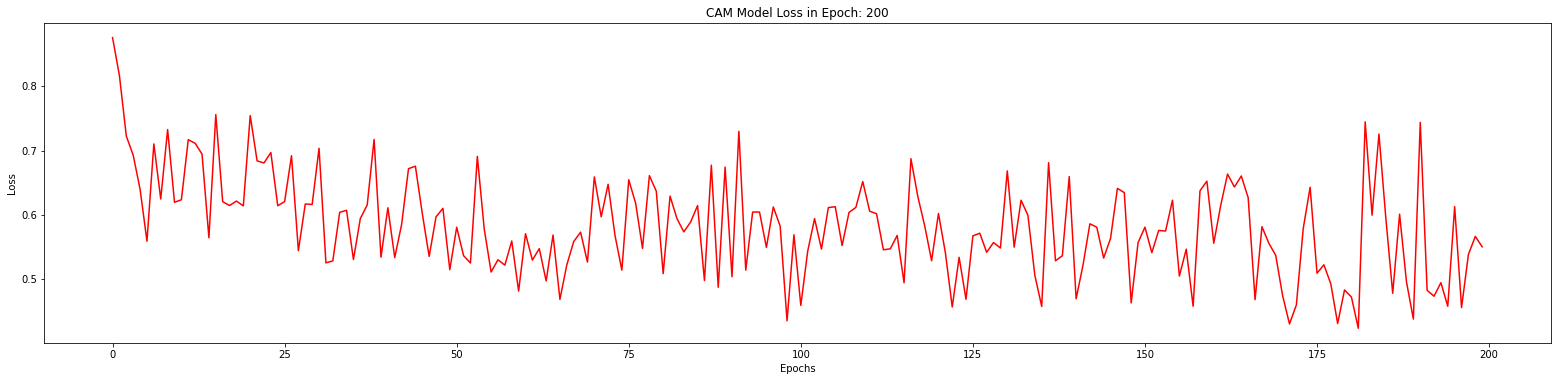

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GNN_Model, GNN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
GNN_Model_test_predicted_labels = []
def GNN_Model_test(test_loader):
  GNN_Model.eval()
  correct = 0
  for bg, labels in test_loader:
    GNN_Model_test_out = GNN_Model(bg, bg.ndata['attr'])
    GNN_Model_test_pred = GNN_Model_test_out.argmax(dim=1) 
    GNN_Model_test_predicted_labels.append(GNN_Model_test_pred)
    correct += int((GNN_Model_test_pred == labels).sum())  
  return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [ ]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.7895


# **GNNExplainer**


In [ ]:
print(len(train_dataset), len(test_dataset))
print(predicted_labels)
predicted_labels = predicted_labels[0].tolist()
print(predicted_labels)

131 57
[tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0])]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]


In [ ]:
Feature_Masks = []
Edge_Masks = []
Graph_Explainer = GNNExplainer(GNN_Model, num_hops=200)

# **Masks Generations**

In [ ]:
for i in range(len(test_dataset)):
  graph, _ = test_dataset[i]
  features = graph.ndata['attr']
  feat_mask, edge_mask = Graph_Explainer.explain_graph(graph, features)
  Feature_Masks.append(feat_mask)
  Edge_Masks.append(edge_mask)

Explain graph:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Explain graph: 100%|██████████| 100/100 [00:00<00:00, 349.36it/s]


In [ ]:
print(len(Feature_Masks))
print(len(Edge_Masks))
print(len(predicted_labels))

57
57
57


# **Group Samples based on the predicted labels**

In [ ]:
Feature_Masks_Pos_HIV = []
Edge_Masks_Pos_HIV = []

Feature_Masks_Neg_HIV = []
Edge_Masks_Neg_HIV = []

for i in range(len(predicted_labels)):
  if predicted_labels[i] == 0:
    Feature_Masks_Neg_HIV.append(Feature_Masks[i])
    Edge_Masks_Neg_HIV.append(Edge_Masks[i])
  elif predicted_labels[i] == 1:
    Feature_Masks_Pos_HIV.append(Feature_Masks[i])
    Edge_Masks_Pos_HIV.append(Edge_Masks[i])

In [ ]:
print(len(Feature_Masks_Pos_HIV), len(Edge_Masks_Pos_HIV))
print(len(Feature_Masks_Neg_HIV), len(Edge_Masks_Neg_HIV))
print(Feature_Masks_Pos_HIV[0])
print(Edge_Masks_Pos_HIV[0])

13 13
44 44
tensor([0.3101, 0.2779, 0.2451, 0.6635, 0.3120, 0.7454, 0.3205])
tensor([0.1816, 0.8705, 0.8976, 0.2134, 0.2219, 0.2226, 0.2321, 0.2590, 0.2535,
        0.2082, 0.1483, 0.2213, 0.2648, 0.1445, 0.2732, 0.7242, 0.6231, 0.6672,
        0.1914, 0.1956, 0.6910, 0.7539, 0.7232, 0.8156, 0.1511, 0.7958])


In [ ]:
Feature_Masks_Pos_HIV = torch.stack(Feature_Masks_Pos_HIV).cpu().detach().numpy()
Feature_Masks_Pos_HIV = Feature_Masks_Pos_HIV.tolist()
print(Feature_Masks_Pos_HIV)

Feature_Masks_Neg_HIV = torch.stack(Feature_Masks_Neg_HIV).cpu().detach().numpy()
Feature_Masks_Neg_HIV = Feature_Masks_Neg_HIV.tolist()
print(Feature_Masks_Neg_HIV)

[[0.31011366844177246, 0.2778570353984833, 0.24506980180740356, 0.6634930968284607, 0.31201615929603577, 0.7454309463500977, 0.32049545645713806], [0.28180131316185, 0.2934511601924896, 0.273141473531723, 0.6642354130744934, 0.24793948233127594, 0.7130045294761658, 0.2846207618713379], [0.28887122869491577, 0.6965880990028381, 0.2933351397514343, 0.26188555359840393, 0.2722553610801697, 0.2648410201072693, 0.2950420081615448], [0.27780598402023315, 0.27341145277023315, 0.26866182684898376, 0.29044973850250244, 0.26983726024627686, 0.7131449580192566, 0.2880266606807709], [0.2920805513858795, 0.26809823513031006, 0.26052069664001465, 0.7150413990020752, 0.24568083882331848, 0.25347596406936646, 0.3004719018936157], [0.28178155422210693, 0.25777921080589294, 0.2820892333984375, 0.7091099619865417, 0.2838236093521118, 0.6727966666221619, 0.3004976212978363], [0.274202436208725, 0.27950534224510193, 0.2803364098072052, 0.257301926612854, 0.26767483353614807, 0.6668092012405396, 0.271424591

# **Average Masks in Class level**

In [ ]:
Feature_Masks_Pos_HIV_Averaged = np.mean(Feature_Masks_Pos_HIV, axis=0)
Feature_Masks_Neg_HIV_Averaged = np.mean(Feature_Masks_Neg_HIV, axis=0)

In [ ]:
def GNNExplainer_Masks_Graph_Feature_Masks(average_feature_masks):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Graph Attributes")
  plt.ylabel('Averaged Feature Masks')
  plt.title("Averaged Graphs Feature Mask in Class : " + "POSITIVE HIV")
  
  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Graph Attributes")
  plt.ylabel('Averaged Feature Masks')
  plt.title("Averaged Graphs Feature Mask in Class : " + "NEGATIVE HIV")

  ax1.plot(average_feature_masks[0], color='r')
  ax2.plot(average_feature_masks[1], color='r')


  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Averaged_Feature_Masks_in_each_Class" + ".png")
  plt.show()

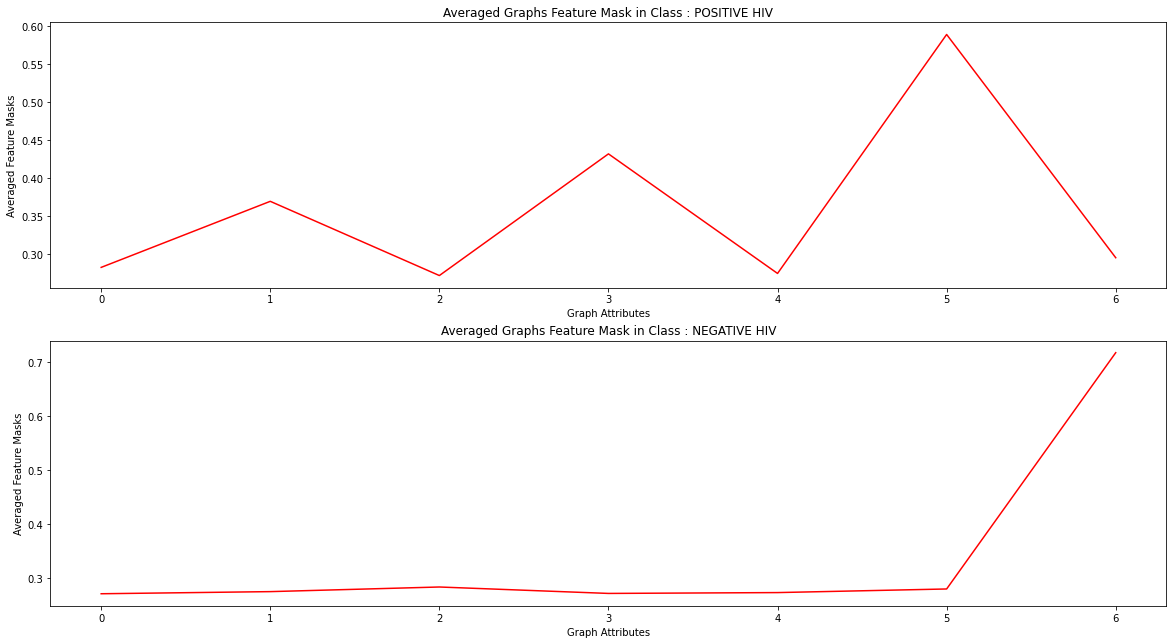

In [ ]:
GNNExplainer_Masks_Graph_Feature_Masks([Feature_Masks_Pos_HIV_Averaged, Feature_Masks_Neg_HIV_Averaged])